# Image Denoising Autoencoder
Welcome to this notebook! Here we will explore **unsupervised image denoising** using a **Convolutional Autoencoder** on the **STL-10 dataset**.  

✨ What you’ll see in this notebook:

1. Load and visualize STL-10 images (100k unlabeled for training + 8k test for validation).  
2. Apply **Gaussian noise** to images to simulate corruption.  
3. Build a **lightweight Conv Autoencoder** to learn to denoise.  
4. Train the model while tracking **L1 loss and PSNR**.  
5. Visualize **Original → Noisy → Denoised** images and the learning progression.  




## 1. Environment Setup ⚙️

- Import core libraries and check **PyTorch version**.  
- Select device: GPU if available, otherwise CPU.  
- Set **random seeds** for reproducibility.  
- Enable **cuDNN optimizations** for faster training.

> 🔹 This ensures consistent results across runs and maximizes GPU performance.


In [1]:
import torch
import random
import os
import numpy as np

# PyTorch version
print(f"PyTorch version: {torch.__version__}")

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

# cuDNN settings for speed
torch.backends.cudnn.benchmark = True
torch.backends.cudnn.deterministic = False

print("Seeds set and cuDNN tuned for speed")


PyTorch version: 2.6.0+cu124
Using device: cuda
Seeds set and cuDNN tuned for speed


## 2. Load STL-10 Dataset 📦

- Training: `split='unlabeled'` → **100,000 images**.  
- Validation: `split='test'` → **8,000 images**.  
- Transform: `ToTensor()` → convert to [0,1] range.  

> 🔹 Labels are not used; denoising is **unsupervised**.  
> 🔹 Batch size = 64 to balance GPU memory and speed.


In [2]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Transformations: Convert images to tensor
transform = transforms.Compose([transforms.ToTensor()])

# Persistent cache directory (safe across sessions)
data_root = os.path.expanduser("~/.cache/torch/datasets")
os.makedirs(data_root, exist_ok=True)

# STL-10: 100k unlabeled for training, 8k test images
train_dataset = datasets.STL10(
    root=data_root,
    split='unlabeled',
    download=True,
    transform=transform
)
test_dataset = datasets.STL10(
    root=data_root,
    split='test',
    download=True,
    transform=transform
)

batch_size = 64  # smaller for 96x96 images

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=4,
    pin_memory=True
)
test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=4,
    pin_memory=True
)

print(f"Training samples: {len(train_dataset):,}")
print(f"Test samples: {len(test_dataset):,}")
print(f"Batch size: {batch_size}")
print(f"Training batches: {len(train_loader):,}")


100%|██████████| 2.64G/2.64G [02:45<00:00, 16.0MB/s]


Training samples: 100,000
Test samples: 8,000
Batch size: 64
Training batches: 1,563


## 3. Visualizing Noise Effects 🎨 

- Define `add_noise` function to add **Gaussian noise**.  
- Try different noise levels: **0.2, 0.4, 0.6, 0.8**.  
- Training: **random noise** (0.2–0.6) per batch for robustness.  
- Validation: **fixed noise** (0.4) for consistent evaluation.  

> ⚡ Observing noise helps understand **the challenge the autoencoder faces**!


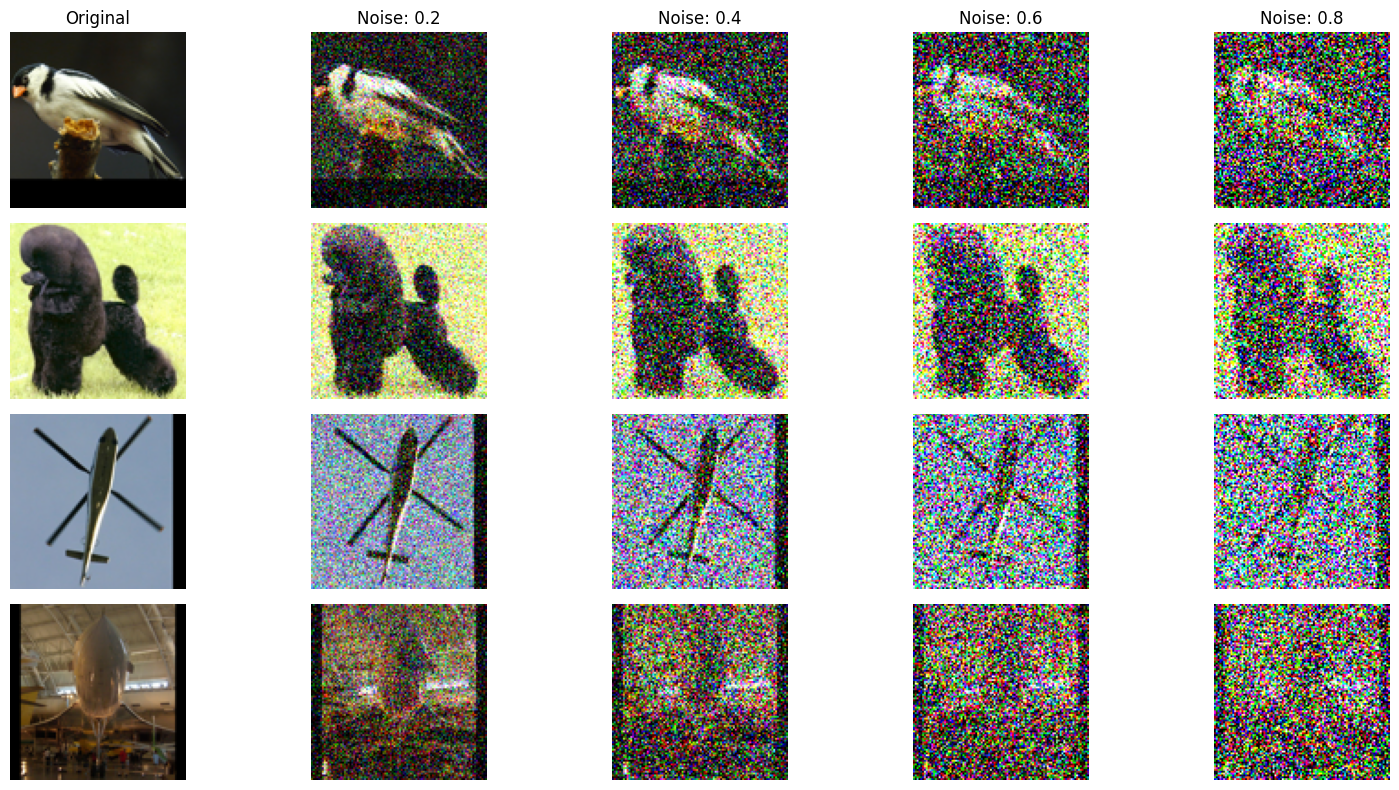

In [3]:
import matplotlib.pyplot as plt

def add_noise(images, noise_factor=0.4):
    """
    Add Gaussian noise to images in [0,1] range and clamp the result.
    """
    noise = noise_factor * torch.randn_like(images)
    noisy = images + noise
    return torch.clamp(noisy, 0.0, 1.0)

# Visualize noise effects on first batch
sample_batch, _ = next(iter(train_loader))
noise_levels = [0.2, 0.4, 0.6, 0.8]

plt.figure(figsize=(16, 8))
for img_idx in range(4):
    # Original image
    plt.subplot(4, 5, img_idx*5 + 1)
    img_display = sample_batch[img_idx].permute(1, 2, 0)
    plt.imshow(img_display)
    if img_idx == 0: plt.title('Original', fontsize=12)
    plt.axis('off')
    
    # Noisy images
    for noise_idx, nf in enumerate(noise_levels):
        plt.subplot(4, 5, img_idx*5 + noise_idx + 2)
        noisy = add_noise(sample_batch[img_idx:img_idx+1], nf)[0].permute(1, 2, 0)
        plt.imshow(noisy)
        if img_idx == 0: plt.title(f'Noise: {nf}', fontsize=12)
        plt.axis('off')

plt.tight_layout()
plt.show()


## 4. Convolutional Autoencoder Architecture 🏗️

- **Encoder:** Downsamples → captures high-level features.  
- **Decoder:** Upsamples → reconstructs original image.  
- Activation: ReLU for hidden layers, Sigmoid for output.  

> 🔹 Latent space is the compressed feature representation.  
> 🔹 Lightweight network: fast training but limited fine-detail recovery.


In [4]:
import torch.nn as nn

class STL10DenoisingAutoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        # Encoder: 96→48→24→12→6
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, 3, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 128, 3, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 256, 3, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 512, 3, stride=2, padding=1),
            nn.ReLU(inplace=True)
        )
        # Decoder: 6→12→24→48→96
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(512, 256, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(256, 128, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(64, 3, 3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

# Instantiate model
model = STL10DenoisingAutoencoder().to(device)

# Test forward pass
test_input = torch.randn(1, 3, 96, 96, device=device)
with torch.no_grad():
    test_output = model(test_input)

print(f"Input shape: {test_input.shape}, Output shape: {test_output.shape}")
print(f"Total parameters: {sum(p.numel() for p in model.parameters()):,}")


Input shape: torch.Size([1, 3, 96, 96]), Output shape: torch.Size([1, 3, 96, 96])
Total parameters: 3,101,443


## 5. Training Setup 🏃 

- **Loss:** L1 pixel-wise loss (sharper than MSE).  
- **Optimizer:** AdamW with weight decay.  
- **Scheduler:** CosineAnnealingLR → smooth LR decay.  
- **Mixed Precision:** Enabled on GPU for speed.  

> 🎯 Selected **visualization epochs**: 1, 5, 10, 20 for learning progression.


In [5]:
import torch.optim as optim
from math import log10
import time

# Loss function
criterion = nn.L1Loss()  # pixel-wise loss

# Optimizer
base_lr = 1e-3
optimizer = optim.AdamW(model.parameters(), lr=base_lr, weight_decay=1e-5)

# Learning rate scheduler
epochs = 20
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

# AMP setup
amp_enabled = (device.type == "cuda")
scaler = torch.amp.GradScaler(enabled=amp_enabled)

# For visualization during training
visualization_epochs = [1, 5, 10, 20]
model_states = {}
sample_images_for_viz = None
sample_noisy_for_viz = None

print(f"Training {epochs} epochs with mixed precision: {amp_enabled}")


Training 20 epochs with mixed precision: True


## 6. Training Loop 🚀 

Each epoch:

1. **Training**  
   - Add random noise (0.2–0.6).  
   - Forward pass → L1 loss → backprop → update weights.  

2. **Validation**  
   - Fixed noise (0.4) on 8k test images.  
   - Compute **L1 loss** and **PSNR**.  

3. **Snapshots for visualization**  
   - Save models at selected epochs for plotting learning progression.  

> PSNR (Peak Signal-to-Noise Ratio) measures **visual quality** improvement over epochs.


In [ ]:
train_losses, test_losses, test_psnrs = [], [], []

def psnr(mse):
    """Compute PSNR from MSE"""
    return 10.0 * -np.log10(max(mse, 1e-10))

start_time = time.time()

for epoch in range(epochs):
    epoch_start = time.time()
    model.train()
    running_loss = 0.0

    # Training
    for images, _ in train_loader:
        images = images.to(device, non_blocking=True)
        noisy_images = add_noise(images, np.random.uniform(0.2, 0.4))

        optimizer.zero_grad(set_to_none=True)
        with torch.amp.autocast(device_type=device.type, enabled=amp_enabled):
            outputs = model(noisy_images)
            loss = criterion(outputs, images)

        # Backpropagation with AMP
        scaler.scale(loss).backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item()

    avg_train = running_loss / len(train_loader)

    # Validation
    model.eval()
    val_loss, val_mse = 0.0, 0.0
    with torch.no_grad(), torch.amp.autocast(device_type=device.type, enabled=amp_enabled):
        for images, _ in test_loader:
            images = images.to(device, non_blocking=True)
            noisy_images = add_noise(images, 0.3)
            outputs = model(noisy_images)
            val_loss += criterion(outputs, images).item()
            val_mse += nn.MSELoss(reduction='mean')(outputs, images).item()

    avg_val = val_loss / len(test_loader)
    avg_psnr = psnr(val_mse / len(test_loader))

    train_losses.append(avg_train)
    test_losses.append(avg_val)
    test_psnrs.append(avg_psnr)

    # Save model states for visualization
    current_epoch = epoch + 1
    if current_epoch in visualization_epochs:
        model_states[current_epoch] = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
        if sample_images_for_viz is None:
            test_batch, _ = next(iter(test_loader))
            sample_images_for_viz = test_batch[:2].to(device)
            sample_noisy_for_viz = add_noise(sample_images_for_viz, 0.3)

        print(f"Saved model state for epoch {current_epoch}")

    scheduler.step()
    epoch_time = time.time() - epoch_start
    print(f"Epoch {current_epoch}/{epochs} | Train L1: {avg_train:.4f} | Val L1: {avg_val:.4f} | Val PSNR: {avg_psnr:.2f} dB | Time: {epoch_time:.1f}s")

print(f"Training completed in {(time.time() - start_time)/60:.1f} minutes")


Saved model state for epoch 1
Epoch 1/20 | Train L1: 0.0968 | Val L1: 0.0779 | Val PSNR: 19.35 dB | Time: 46.2s
Epoch 2/20 | Train L1: 0.0697 | Val L1: 0.0658 | Val PSNR: 20.39 dB | Time: 43.0s
Epoch 3/20 | Train L1: 0.0654 | Val L1: 0.0633 | Val PSNR: 20.77 dB | Time: 43.0s
Epoch 4/20 | Train L1: 0.0629 | Val L1: 0.0610 | Val PSNR: 20.99 dB | Time: 43.0s
Saved model state for epoch 5
Epoch 5/20 | Train L1: 0.0613 | Val L1: 0.0611 | Val PSNR: 21.12 dB | Time: 43.3s
Epoch 6/20 | Train L1: 0.0603 | Val L1: 0.0592 | Val PSNR: 21.28 dB | Time: 43.0s
Epoch 7/20 | Train L1: 0.0589 | Val L1: 0.0579 | Val PSNR: 21.44 dB | Time: 43.0s
Epoch 8/20 | Train L1: 0.0580 | Val L1: 0.0577 | Val PSNR: 21.49 dB | Time: 42.9s
Epoch 9/20 | Train L1: 0.0574 | Val L1: 0.0581 | Val PSNR: 21.43 dB | Time: 42.9s
Saved model state for epoch 10
Epoch 10/20 | Train L1: 0.0569 | Val L1: 0.0563 | Val PSNR: 21.63 dB | Time: 43.1s
Epoch 11/20 | Train L1: 0.0567 | Val L1: 0.0562 | Val PSNR: 21.65 dB | Time: 42.9s
Epoch

## 7. Training Curves 📈 

- Plot **Training & Validation L1 Loss** over epochs.  
- Plot **Validation PSNR** to see image quality improvement.  

> 🔹 Close train/val curves → model generalizes well.  
> 🔹 PSNR rising → better denoising performance.


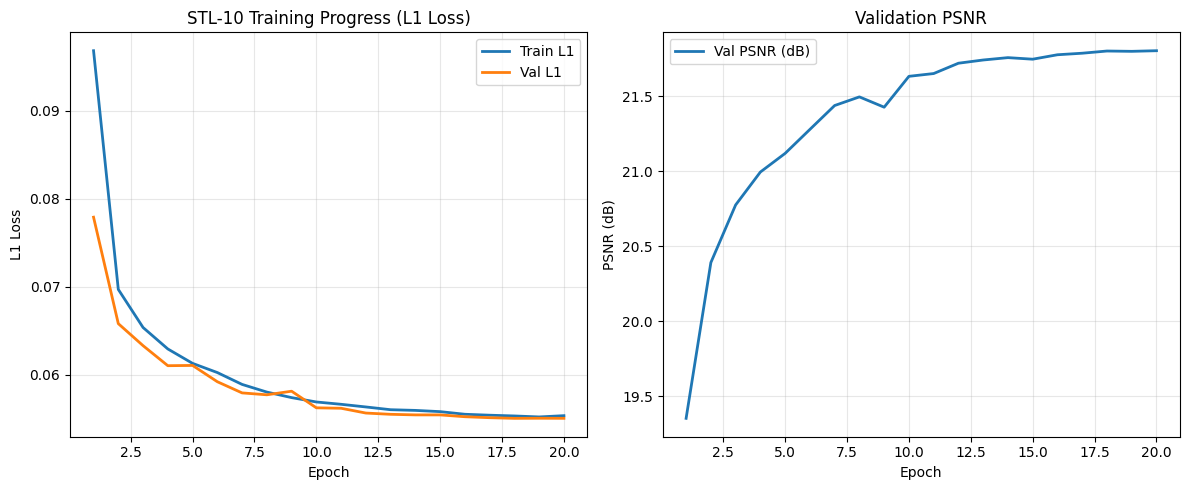

In [7]:
plt.figure(figsize=(12, 5))
epochs_range = range(1, epochs + 1)

# L1 Loss
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses, label='Train L1', linewidth=2)
plt.plot(epochs_range, test_losses,  label='Val L1', linewidth=2)
plt.title('STL-10 Training Progress (L1 Loss)')
plt.xlabel('Epoch'); plt.ylabel('L1 Loss')
plt.legend(); plt.grid(True, alpha=0.3)

# Validation PSNR
plt.subplot(1, 2, 2)
plt.plot(epochs_range, test_psnrs, label='Val PSNR (dB)', linewidth=2)
plt.title('Validation PSNR')
plt.xlabel('Epoch'); plt.ylabel('PSNR (dB)')
plt.legend(); plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## 8. Best & Worst Denoised Images 🔍 

- We rank validation images by **PSNR**.  
- Display the **2 best and 2 worst images** after denoising.  
- Columns: Original → Noisy → Denoised.  

> 💡 Helps visually identify where the autoencoder performs exceptionally and where it struggles.


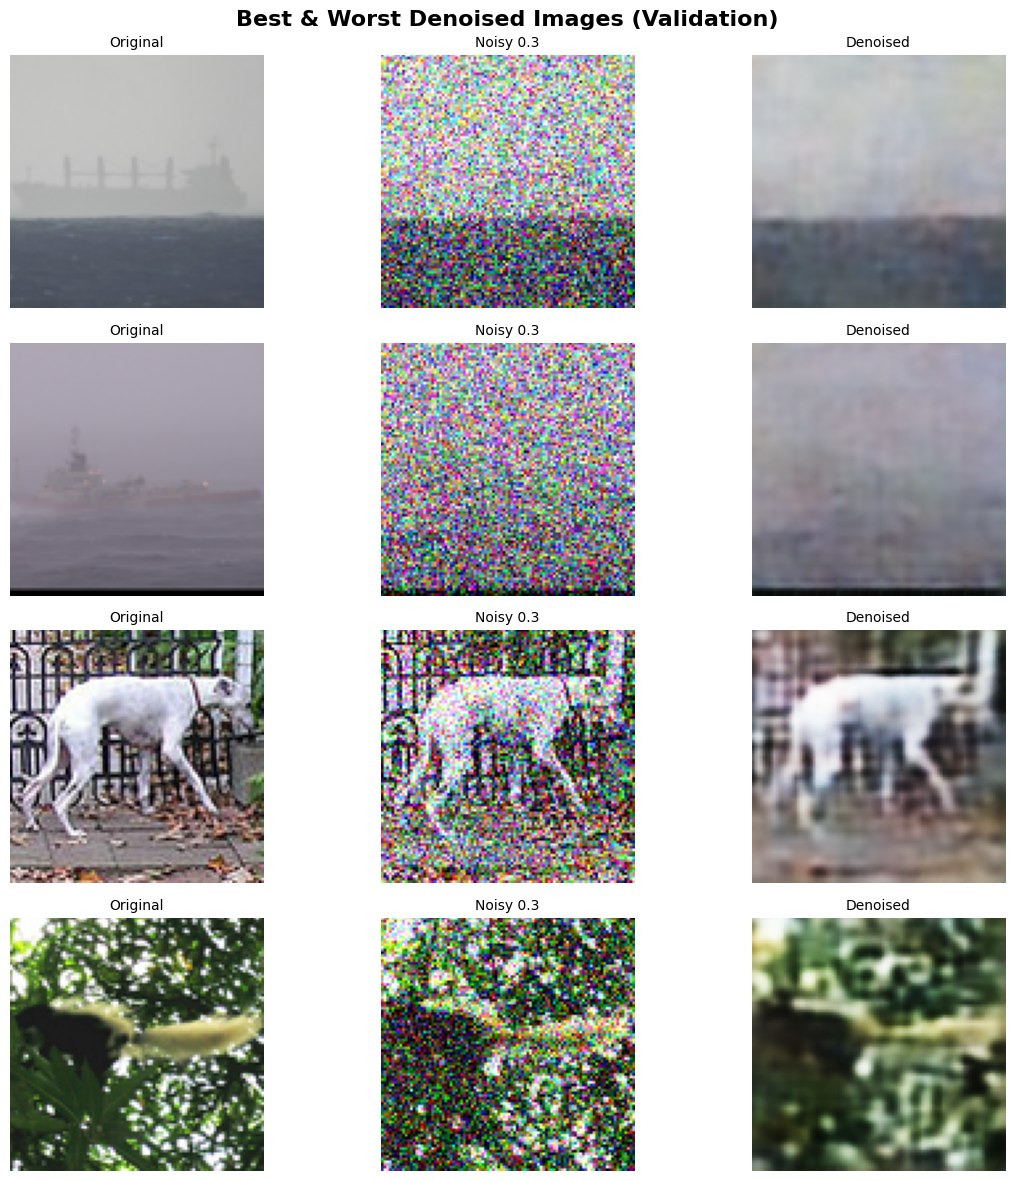

In [8]:
psnr_list_all = []
images_list_all = []

# Autocast for validation
with torch.no_grad(), torch.amp.autocast(device_type=device.type, enabled=amp_enabled):
    for images, _ in test_loader:
        images = images.to(device)
        noisy_images = add_noise(images, 0.3)  # validation noise
        outputs = model(noisy_images)

        # Compute per-image MSE and PSNR
        mse = ((outputs - images) ** 2).mean(dim=[1,2,3])
        image_psnr = 10 * torch.log10(1 / mse)
        psnr_list_all.append(image_psnr)

        # Store images for plotting (CPU float)
        images_list_all.append((
            images.detach().cpu().float(),
            noisy_images.detach().cpu().float(),
            outputs.detach().cpu().float()
        ))

# Flatten PSNR list
psnr_list = torch.cat(psnr_list_all)

# Flatten image lists
images_list = [(img, noisy, out) 
               for batch in images_list_all 
               for img, noisy, out in zip(*batch)]

# Select top 2 best and worst images
best_indices = psnr_list.topk(2).indices
worst_indices = psnr_list.topk(2, largest=False).indices
selected_indices = torch.cat([best_indices, worst_indices])

# Utility to display image safely
def display_stl_image(img_tensor, title, ax):
    img_np = img_tensor.clamp(0,1).permute(1,2,0).numpy()
    ax.imshow(img_np)
    ax.set_title(title, fontsize=10)
    ax.axis('off')

# Plot best and worst reconstructions
fig, axes = plt.subplots(4, 3, figsize=(12, 12))
for i, idx in enumerate(selected_indices):
    orig, noisy, denoised = images_list[idx]
    display_stl_image(orig, "Original", axes[i,0])
    display_stl_image(noisy, "Noisy 0.3", axes[i,1])
    display_stl_image(denoised, "Denoised", axes[i,2])

plt.suptitle("Best & Worst Denoised Images (Validation)", fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()


## 9. PSNR Distribution Across Validation Images 📈 

- We visualize **PSNR per image** as a boxplot.  
- This shows **how performance varies across the dataset**.  
- Outliers indicate images that are particularly easy or difficult to denoise.


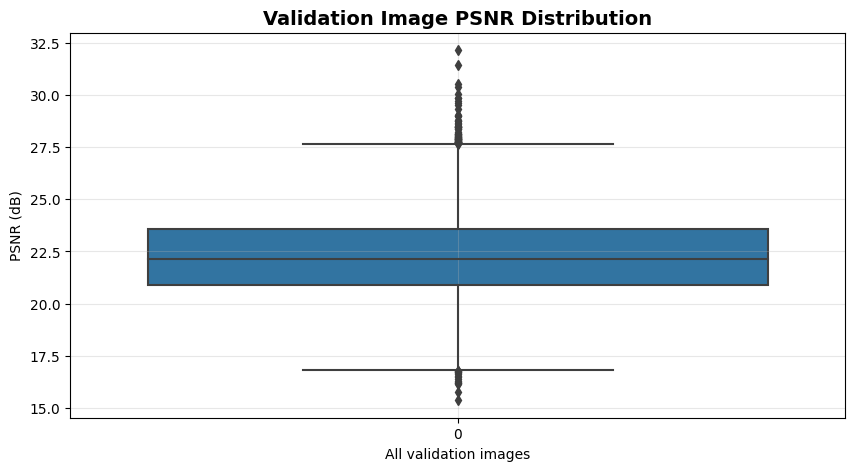

Median PSNR: 22.26 dB
Min PSNR: 15.37 dB
Max PSNR: 32.14 dB


In [9]:
import seaborn as sns

psnr_values = psnr_list.cpu().numpy()

plt.figure(figsize=(10,5))
sns.boxplot(psnr_values)
plt.title("Validation Image PSNR Distribution", fontsize=14, fontweight='bold')
plt.ylabel("PSNR (dB)")
plt.xlabel("All validation images")
plt.grid(alpha=0.3)
plt.show()

print(f"Median PSNR: {psnr_values.mean():.2f} dB")
print(f"Min PSNR: {psnr_values.min():.2f} dB")
print(f"Max PSNR: {psnr_values.max():.2f} dB")


## 10. Epoch-by-Epoch Reconstruction 🎥 

- Load saved model snapshots at epochs 1, 5, 10, 20.  
- Compare **Original → Noisy → Denoised** images.  

> Observations:  
- Epoch 1: blurry, basic colors.  
- Epoch 5: shapes emerge, colors stabilize.  
- Epoch 10: recognizable objects, smoother edges.  
- Epoch 20: clean reconstructions, visually pleasant.  



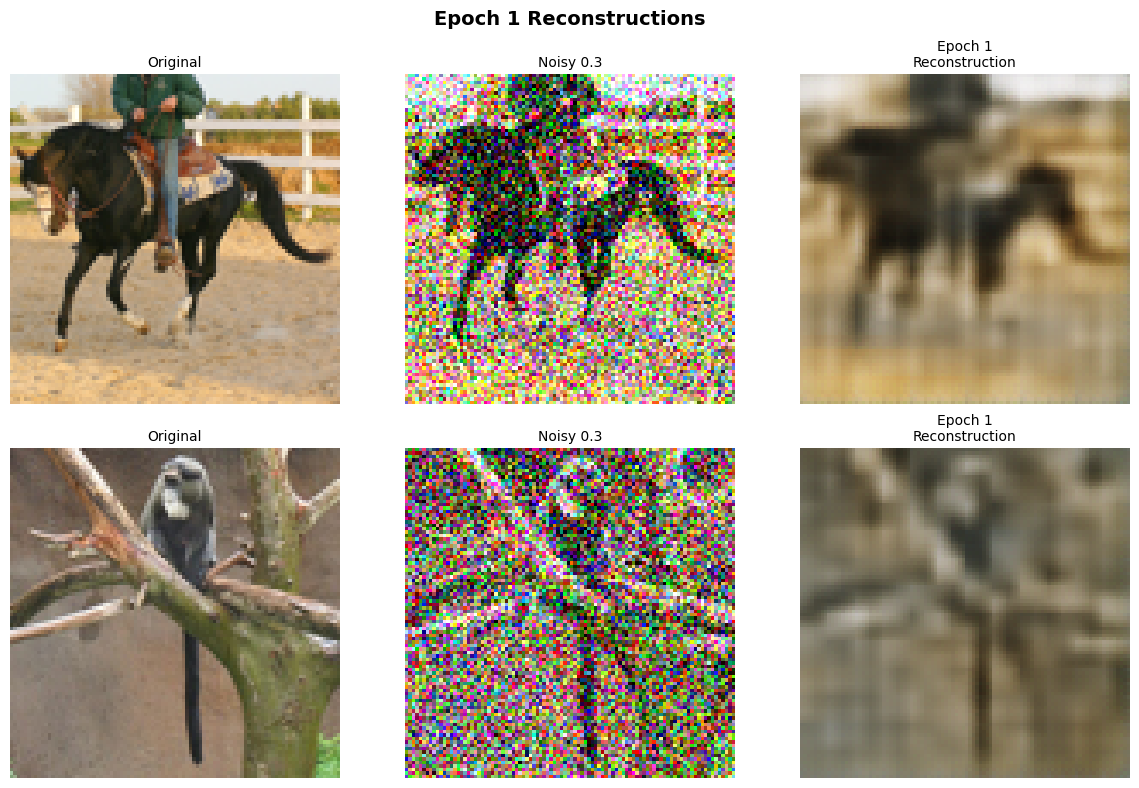

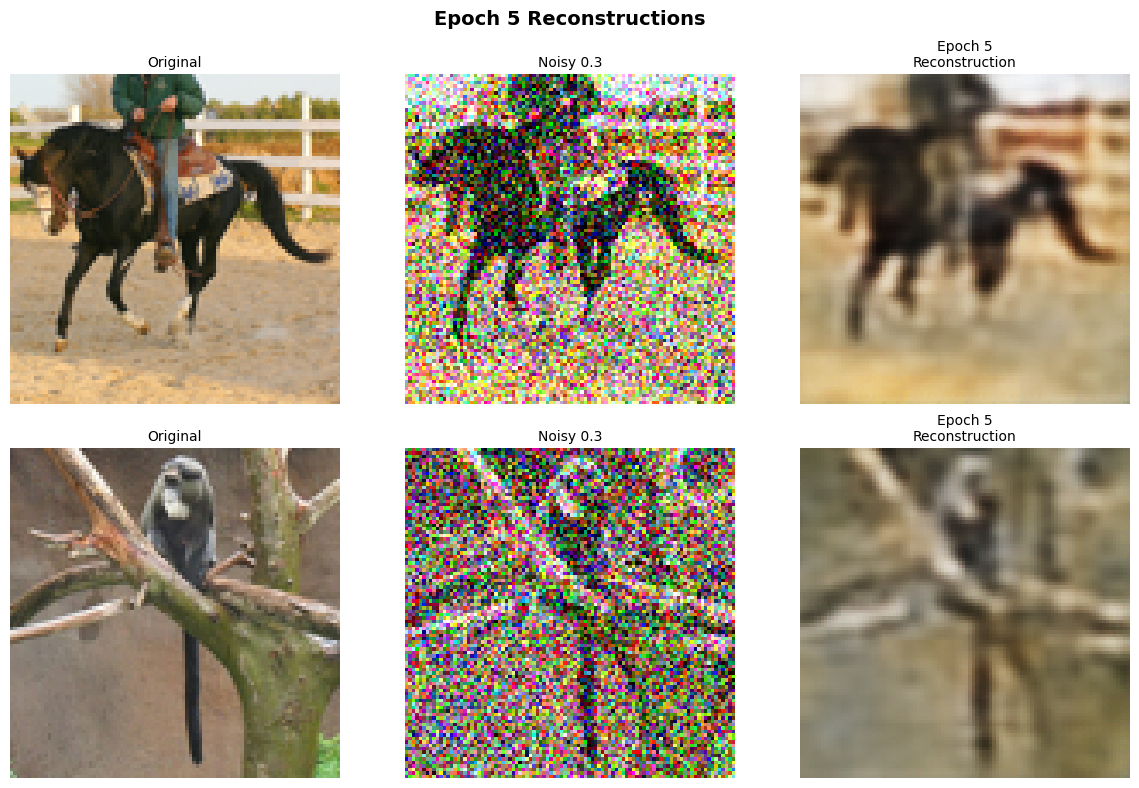

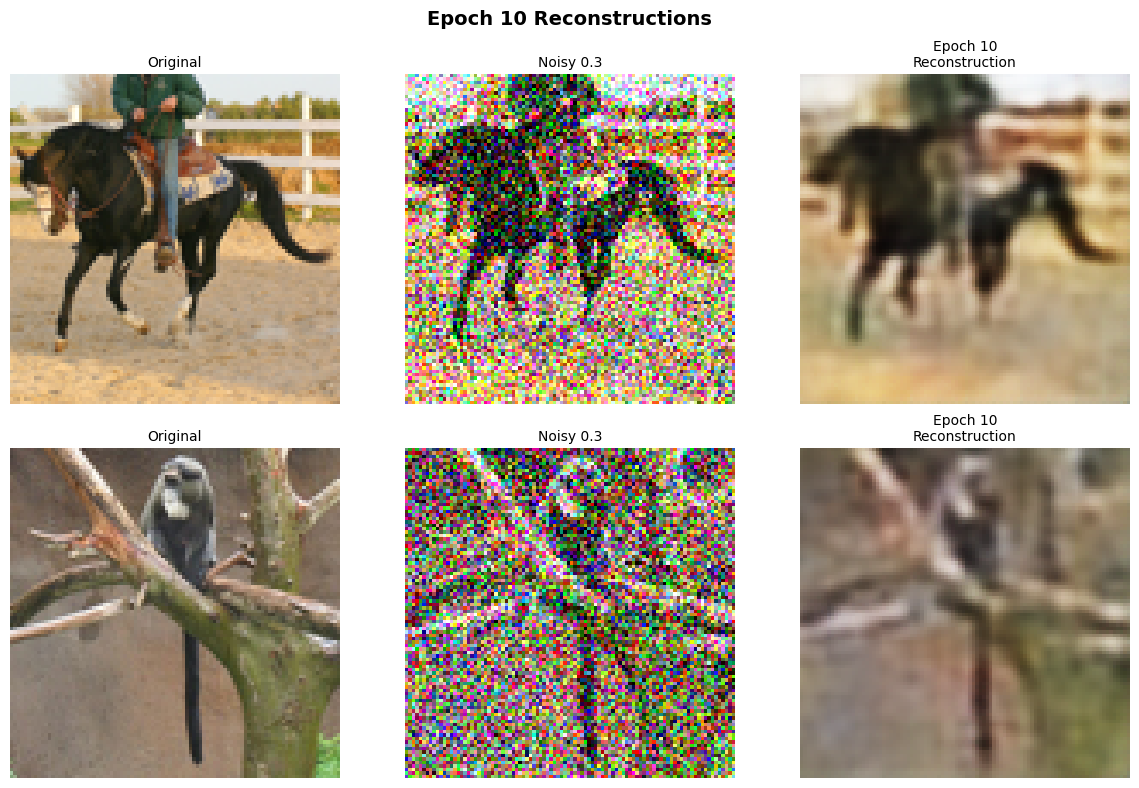

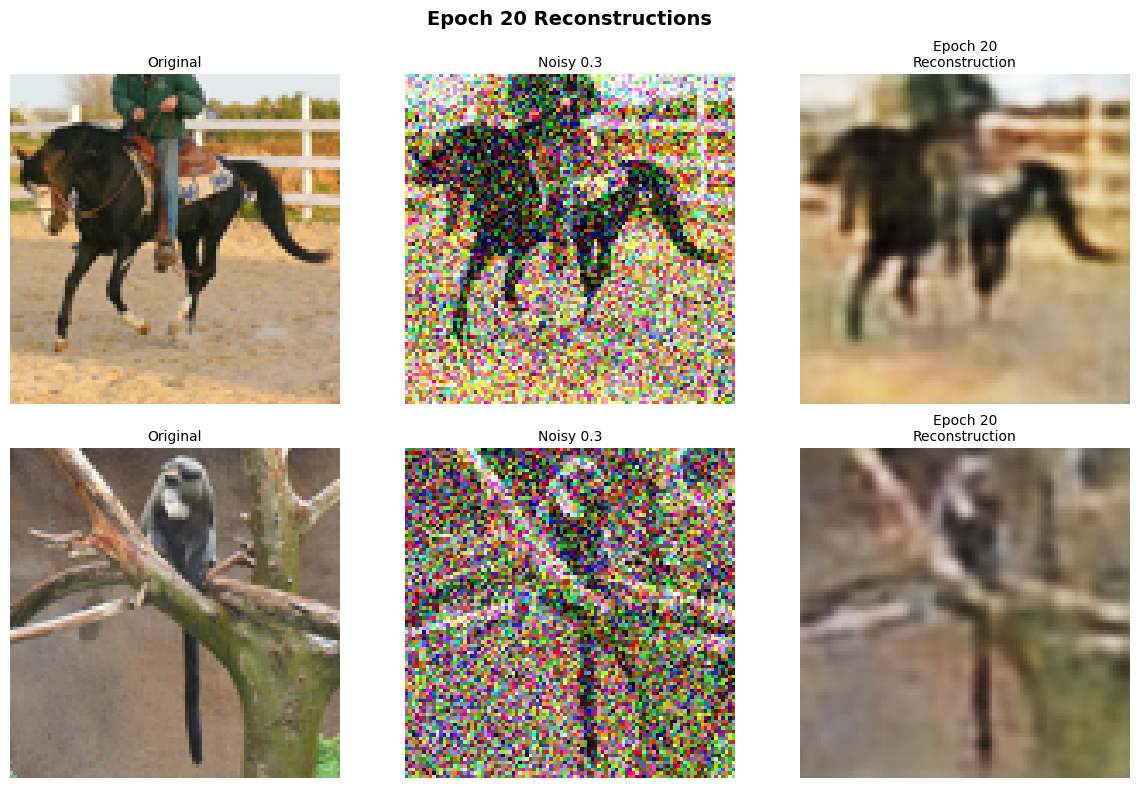

In [10]:
# Function to safely display STL-10 image
def display_stl_image(img_tensor, title, ax):
    img_np = img_tensor.detach().cpu().float().clamp(0,1).permute(1,2,0).numpy()
    ax.imshow(img_np)
    ax.set_title(title, fontsize=10)
    ax.axis('off')

with torch.no_grad():
    for epoch_num in visualization_epochs:
        # Load saved model state for this epoch
        model.load_state_dict(model_states[epoch_num])
        model.eval()

        # Reconstruct sample noisy images
        reconstructions = model(sample_noisy_for_viz)

        fig, axes = plt.subplots(2, 3, figsize=(12, 8))
        for i in range(2):
            display_stl_image(sample_images_for_viz[i], "Original", axes[i,0])
            display_stl_image(sample_noisy_for_viz[i], "Noisy 0.3", axes[i,1])
            display_stl_image(reconstructions[i], f"Epoch {epoch_num}\nReconstruction", axes[i,2])

        plt.suptitle(f"Epoch {epoch_num} Reconstructions", fontsize=14, fontweight='bold')
        plt.tight_layout()
        plt.show()


## 11. Save Trained Model 💾 

- Save **weights, metrics, and visualization states**.  
- Include metadata: dataset, architecture, L1 loss, best PSNR.  
- Allows **future inference or visualization without retraining**.  



In [11]:
from datetime import datetime

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
model_path = f'stl10_dae_{timestamp}.pth'

torch.save({
    'model_state_dict': model.state_dict(),
    'train_losses': train_losses,
    'test_losses': test_losses,
    'test_psnrs': test_psnrs,
    'epochs': epochs,
    'model_states': model_states,
    'architecture': 'STL-10 Conv Denoising Autoencoder (AdamW+Cosine+AMP)',
    'dataset': 'STL-10',
    'final_train_L1': train_losses[-1],
    'final_val_L1': test_losses[-1],
    'best_psnr_db': max(test_psnrs)
}, model_path)

print(f"Model saved: {model_path} ({os.path.getsize(model_path)/1024/1024:.2f} MB)")


Model saved: stl10_dae_20250904_083220.pth (59.18 MB)
